# Two Moons Simformer Conditional Flow Matching Example

This notebook demonstrates how to train and sample from a conditional flow-matching model on the Two Moons task using JAX and Flax. We cover environment setup, data generation, model definition, training, sampling, and evaluation.

## 1. Environment Setup

We set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage. This section also ensures compatibility with Google Colab.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [3]:
# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
import os
# os.environ['JAX_PLATFORMS']="cuda"
os.environ['JAX_PLATFORMS']="cpu"

In [4]:
experiment_id = 1

### Set Training and Model Restoration Flags

Configure whether to restore a pretrained model or train from scratch.

In [5]:
restore_model=True
train_model=False

### Set Checkpoint Directory

Specify the directory for saving and restoring model checkpoints.

In [6]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = f"{notebook_path}/checkpoints/two_moons_simformer"

os.makedirs(checkpoint_dir, exist_ok=True)

## 2. Library Imports and JAX Mesh Setup

Import required libraries and set up the JAX mesh for sharding.

In [7]:
import orbax.checkpoint as ocp

In [8]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from optax.contrib import reduce_on_plateau

from numpyro import distributions as dist

from corner import corner

import numpy as np

from tqdm import tqdm

from functools import partial

# Define the mesh for JAX sharding (for model restoration on CPU/GPU)
devices = jax.devices()
# mesh = jax.sharding.Mesh(devices, axis_names=('data',)) # A simple 1D mesh


## 3. Optimizer and Learning Rate Schedule Parameters

Define optimizer hyperparameters and learning rate scheduling.

In [9]:
# @markdown Define optimizer and learning rate schedule parameters
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Relative tolerance for measuring the new optimum:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
RTOL = 1e-4  # @param{type:"number"}
# @markdown learnign rate
MAX_LR = 1e-3  # @param{type:"number"}
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR

## 4. Task and Dataset Setup

Define the Two Moons task and prepare training and validation datasets.

In [10]:
# from sbi_utils.sbi_tasks import TwoMoons
# from sbi_utils.dataloader import InfiniteDataLoader

from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver

from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

### Define the Task

In [11]:
from gensbi_examples.tasks import TwoMoons
task = TwoMoons()

/lhome/ific/a/aamerio/miniforge3/envs/gensbi/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at grain/proto/execution_summary.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


./task_data/data_two_moons.npz already exists, skipping download.


In [12]:
task.true_parameters[8]

array([[0.6775234 , 0.01315427]], dtype=float32)

In [13]:
obs, reference_samples = task.get_reference(num_observation=8)

#### Visualize Reference Samples

Plot the reference samples from the Two Moons task.

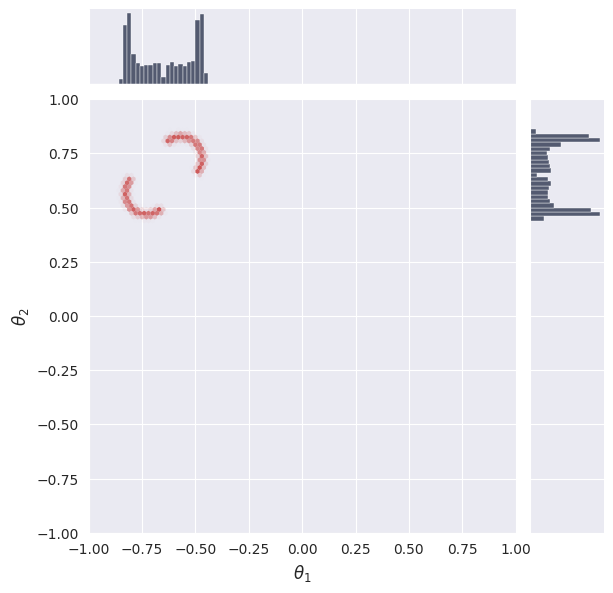

In [14]:
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=100,range=[(-1.,1.),(-1.,1.)], backend="seaborn", plot_levels=False)
plt.show()

## 5. Dataset Preparation

Create training and validation datasets for the model.

In [15]:
# make a dataset
nsamples = int(1e5)

In [16]:
batch_size = 4*1024 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memory
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset()

dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

In [17]:
next(dataset_iter).shape, next(val_dataset_iter).shape

((4096, 4), (512, 4))

## 6. Model Definition

Define the Simformer model and the conditional flow-matching loss.

**Note:**  
- The model uses *edge masks* as attention masks, which are crucial for controlling which variables are attended to during training and inference. These masks enable both posterior estimation (conditioning on observed data) and unconditional density estimation (no conditioning).
- The *marginalization* function is used to construct edge masks that marginalize out arbitrary variables, allowing the model to learn and evaluate arbitrary marginal distributions.

In [18]:
from gensbi.models import Simformer, SimformerParams, SimformerCFMLoss

In [19]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [20]:
dim_theta = task.dim_theta
dim_data = task.dim_data

dim_joint = task.dim_joint
node_ids = jnp.arange(dim_joint)

In [21]:
params = SimformerParams(
    rngs = nnx.Rngs(0),
    dim_value = 40,
    dim_id = 40, 
    dim_condition = 10, 
    dim_joint= dim_joint,
    fourier_features = 128,
    num_heads = 4,
    num_layers = 8,
    widening_factor = 3,
    qkv_features = 40, # this bottlenecks the transformer features to 40, instead of the token dimension
    num_hidden_layers = 1)

In [22]:
loss_fn_cfm = SimformerCFMLoss(path)

In [23]:
def marginalize(rng: jax.random.PRNGKey, edge_mask: jax.Array):
    # This function creates an edge mask that marginalizes out a single node from the adjacency matrix.
    # By setting the corresponding row and column to False (except the diagonal), we can compute arbitrary marginals.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

In [24]:
# Edge masks are attention masks that control which variables are attended to.
# - undirected_edge_mask: all variables attend to each other (for unconditional density estimation)
# - posterior_faithfull: mask for posterior estimation (conditioning on observed data)
undirected_edge_mask = jnp.ones((dim_joint, dim_joint), dtype=jnp.bool_)
posterior_faithfull = task.get_edge_mask_fn("faithfull")(node_ids, condition_mask=jnp.array([0,0,1,1]))

In [25]:
@partial(jax.jit, static_argnames=["nsamples"])
def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
    mask_joint = jnp.zeros((5*nsamples, dim_joint ), dtype=jnp.bool_)
    mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_data), dtype=jnp.bool_)], axis=-1)
    
    mask1 = jax.random.bernoulli(rng, p=0.3, shape=(nsamples, dim_joint))
    filter = ~jnp.all(mask1, axis=-1)
    mask1 = jnp.logical_and(mask1, filter.reshape(-1,1))

    # masks = jnp.concatenate([mask_joint, mask1, mask_posterior, mask_likelihood], axis=0)
    masks = jnp.concatenate([mask_joint, mask1, mask_posterior], axis=0)
    return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)
    

In [26]:
p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [27]:
def loss_fn_(vf_model, x_1, key: jax.random.PRNGKey):

    batch_size = x_1.shape[0]

    rng_x0, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    x_0 = p0_dist_model.sample(rng_x0, (batch_size,)) # n, T_max, 1
    
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    # faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency by generating edge masks that marginalize out random nodes.
    # This allows the model to learn arbitrary marginal distributions.
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    # edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jnp.concatenate([undirected_edge_mask_, marginal_mask], axis=0)
    # Randomly choose between dense, posterior, and marginal edge masks for each batch element.
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask
    
    loss = loss_fn_cfm(vf_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss

In [28]:
@nnx.jit
def train_loss(vf_model, key: jax.random.PRNGKey):
    x_1 = next(dataset_iter) # n, T_max, 1
    return loss_fn_(vf_model, x_1, key)

In [29]:
@nnx.jit
def val_loss(vf_model, key):
    x_1 = next(val_dataset_iter)
    return loss_fn_(vf_model, x_1, key)

In [30]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [31]:
vf_model = Simformer(params)

## 7. Model Restoration

Restore the model from checkpoint if requested.

In [32]:
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            experiment_id,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

ValueError: User-provided restore item and on-disk value metadata tree structures do not match: {'transformer': {'attention_blocks': {'6': Diff(lhs={'attn': {'key': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[-0.11211352, -0.09104373,  0.07770193, ..., -0.22832346,
         -0.06964488, -0.0856287 ],
        [-0.15226923, -0.04725559,  0.03244665, ...,  0.04344821,
         -0.11649131,  0.090763  ],
        [ 0.09446096,  0.10022021, -0.1149784 , ...,  0.13138556,
         -0.15999517,  0.01600954],
        [ 0.03775585, -0.04401566, -0.05719468, ...,  0.01543713,
         -0.07955366,  0.08413068]],

       [[-0.04425572,  0.02668572, -0.03664873, ..., -0.10843641,
         -0.06074775, -0.12837279],
        [ 0.13602781, -0.01295912,  0.09712885, ..., -0.01934204,
         -0.00834565,  0.02363251],
        [-0.14303875, -0.07468157,  0.07545994, ...,  0.0052059 ,
          0.08334424,  0.15399465],
        [-0.18133058,  0.06774507, -0.1979527 , ...,  0.0556061 ,
          0.01528605, -0.16216756]],

       [[ 0.08936203,  0.10950966, -0.17726125, ...,  0.03572188,
          0.12331175, -0.10995372],
        [-0.19678509, -0.03520354, -0.17435494, ...,  0.15278123,
          0.1931999 , -0.04226888],
        [ 0.10592191,  0.11918098, -0.21832436, ...,  0.07249264,
          0.06047135, -0.03521435],
        [ 0.08087087, -0.0963025 ,  0.05541273, ..., -0.15202266,
          0.033358  , -0.11309784]],

       ...,

       [[-0.1488683 ,  0.05333576,  0.13466848, ..., -0.0701395 ,
         -0.19340175, -0.02118693],
        [-0.02672265,  0.02286239, -0.00496257, ..., -0.00080813,
         -0.01226628,  0.04280077],
        [ 0.05476489,  0.02333113, -0.00337543, ...,  0.15239504,
          0.07687581,  0.05289169],
        [-0.07412488, -0.00689329, -0.08049012, ..., -0.18138225,
         -0.04543952,  0.0156419 ]],

       [[ 0.183769  , -0.06167581, -0.04411524, ..., -0.03023803,
          0.03531089, -0.05831341],
        [-0.00631342, -0.06315495, -0.05023109, ...,  0.04432774,
         -0.00087977,  0.11108647],
        [ 0.06023661,  0.0805066 ,  0.22774692, ...,  0.01191368,
          0.09913598,  0.15796289],
        [-0.19221754,  0.06201435,  0.12286758, ..., -0.02529519,
          0.03409327, -0.16087359]],

       [[ 0.0059962 , -0.09788423,  0.21205983, ...,  0.16115825,
         -0.02466538, -0.17479675],
        [ 0.02305908, -0.08477452, -0.16654503, ...,  0.03252926,
          0.02211001,  0.14817677],
        [ 0.0775918 ,  0.14221655, -0.05827975, ...,  0.10847099,
         -0.0678957 , -0.01814759],
        [-0.00051812, -0.16495351, -0.06686364, ...,  0.11045228,
          0.21352316,  0.01654443]]], dtype=float32)}}, 'out': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[[-0.17856973, -0.01052373,  0.0556648 , ..., -0.15879731,
         -0.07065216,  0.10896541],
        [-0.09620041,  0.00456341, -0.04887236, ..., -0.08451479,
          0.32497504, -0.22845405],
        [ 0.01272014, -0.15762047,  0.22659156, ..., -0.19846898,
          0.11149526, -0.30722556],
        ...,
        [-0.10284219,  0.13228525,  0.03753273, ..., -0.01852126,
         -0.21876696, -0.22176465],
        [ 0.06254363,  0.21542484, -0.02344619, ...,  0.09160519,
         -0.12323721, -0.06563287],
        [-0.03007752,  0.18538891,  0.02666392, ..., -0.07095622,
          0.11209987,  0.04393081]],

       [[ 0.07015202,  0.13052063,  0.09362043, ...,  0.15348855,
          0.25882146, -0.1174196 ],
        [-0.1969599 , -0.12993859, -0.03465374, ...,  0.08366531,
         -0.0153543 ,  0.24112858],
        [ 0.01855909, -0.05218805, -0.08815603, ..., -0.1081982 ,
         -0.15107667,  0.10623855],
        ...,
        [-0.35463172, -0.05490202, -0.22798117, ...,  0.08681168,
         -0.06854595,  0.04074875],
        [-0.19044545, -0.17509657,  0.16358317, ...,  0.04989287,
         -0.04012297, -0.07969011],
        [ 0.11208349,  0.06476413, -0.15884139, ...,  0.05886444,
         -0.07281669,  0.04193099]],

       [[ 0.21746434, -0.04098308, -0.34387878, ...,  0.20406094,
         -0.2266753 ,  0.17338423],
        [-0.0127719 , -0.013091  , -0.06569733, ..., -0.02098369,
         -0.31885424, -0.00285432],
        [-0.01236363, -0.29660627, -0.33669084, ...,  0.12935647,
         -0.12408614, -0.2721504 ],
        ...,
        [ 0.24809565, -0.01917209, -0.05834642, ...,  0.10369768,
         -0.11890749, -0.06147853],
        [ 0.0587528 ,  0.21838766,  0.01048434, ..., -0.17824152,
          0.1649422 ,  0.02829028],
        [-0.24396068,  0.10221276,  0.06173864, ...,  0.11375801,
          0.049826  ,  0.00951387]],

       [[ 0.18498902,  0.17386922, -0.01606615, ..., -0.2213993 ,
          0.06009176, -0.23689018],
        [ 0.15940376,  0.21121834, -0.03687444, ..., -0.32810602,
         -0.05179603, -0.04679875],
        [-0.10761952, -0.3552448 ,  0.05127958, ...,  0.12783982,
         -0.30185547, -0.18602614],
        ...,
        [ 0.02037156, -0.27714896, -0.11745357, ..., -0.07736949,
          0.09422674, -0.15376577],
        [-0.15895513,  0.14104351,  0.20389344, ...,  0.05062627,
         -0.34058976,  0.12044174],
        [-0.07545479, -0.16622211,  0.15558368, ..., -0.12548025,
         -0.2388727 ,  0.09125906]]], dtype=float32)}}, 'query': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[ 0.00815619, -0.06812634, -0.00236885, ...,  0.04302616,
          0.04724644, -0.16810943],
        [ 0.06103063,  0.19385707,  0.03857391, ...,  0.00339844,
         -0.14844157,  0.18640934],
        [ 0.0307199 , -0.02062013,  0.04385888, ..., -0.1685575 ,
          0.20974657,  0.17278054],
        [ 0.07186252, -0.00561664,  0.04897552, ..., -0.03106455,
          0.04619858,  0.1537736 ]],

       [[ 0.03711091, -0.04036805,  0.13690504, ...,  0.03734865,
         -0.07893367,  0.09085641],
        [-0.05102868,  0.02693458, -0.00773706, ...,  0.03329743,
          0.04472559,  0.09418021],
        [ 0.06880395, -0.05192863, -0.06432558, ..., -0.10079026,
         -0.04138754, -0.11656886],
        [-0.06175519, -0.03236255,  0.03219297, ..., -0.03875454,
          0.06490282,  0.06345219]],

       [[-0.07778665,  0.00802615, -0.17300855, ..., -0.05089447,
          0.01751038,  0.08607765],
        [ 0.15149628, -0.06024821,  0.08280018, ..., -0.05875855,
          0.05242457,  0.03508386],
        [-0.16354437,  0.00250286, -0.20228313, ...,  0.07860563,
         -0.0211726 , -0.01165108],
        [ 0.22372882,  0.04987654, -0.10889486, ..., -0.21008721,
         -0.16011117,  0.02688858]],

       ...,

       [[ 0.05185029,  0.04699815,  0.14639379, ..., -0.05030156,
          0.05875724,  0.20504066],
        [ 0.08429772, -0.01025599, -0.14358097, ..., -0.1126405 ,
         -0.15756913,  0.08644044],
        [ 0.07302119, -0.18030395, -0.13355571, ..., -0.1369479 ,
         -0.05857515, -0.14215554],
        [ 0.08901212,  0.11031201,  0.16727905, ..., -0.08765001,
          0.08163981, -0.18191564]],

       [[ 0.02491885, -0.06343619, -0.08507574, ..., -0.20894937,
         -0.10211298,  0.11016945],
        [ 0.09004787,  0.14129916,  0.11226189, ..., -0.0306641 ,
          0.2111502 ,  0.0306052 ],
        [-0.07713924, -0.07163002,  0.08984615, ..., -0.01130319,
         -0.05150753, -0.01435596],
        [-0.1302967 ,  0.23447101,  0.03392123, ...,  0.15104946,
          0.1490322 ,  0.06931497]],

       [[ 0.09949172, -0.01592009,  0.00312354, ..., -0.06691863,
         -0.03782758,  0.22510813],
        [-0.09023628,  0.00402596,  0.01571133, ..., -0.17659143,
          0.1361788 , -0.03235143],
        [ 0.12012044, -0.21969266, -0.06857326, ...,  0.12872235,
          0.1346931 , -0.23557986],
        [ 0.00320977, -0.10591782, -0.08834977, ..., -0.1890953 ,
         -0.05680877, -0.20592466]]], dtype=float32)}}, 'value': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[ 0.120711  , -0.12819573, -0.02081473, ...,  0.04687673,
          0.08400946, -0.00415923],
        [ 0.01341914, -0.11568979, -0.09109263, ...,  0.00235151,
          0.0238793 , -0.04005001],
        [-0.18266405, -0.14643541, -0.1611217 , ...,  0.05064715,
         -0.05802625,  0.02569966],
        [-0.10187548, -0.13745618, -0.00989163, ..., -0.16883749,
         -0.06910031, -0.15495583]],

       [[-0.23954155, -0.007792  , -0.12972024, ..., -0.20266175,
          0.08377763,  0.04151817],
        [ 0.16578668,  0.05152987,  0.01915982, ..., -0.06715572,
         -0.2290606 , -0.05315302],
        [-0.11245806, -0.14298566,  0.01777609, ...,  0.02253536,
         -0.02771283, -0.06765835],
        [-0.03666681,  0.17414364,  0.08786277, ...,  0.06701461,
          0.08618823, -0.05793658]],

       [[-0.01329027,  0.17165023,  0.08481   , ...,  0.05441276,
          0.05070852, -0.04844107],
        [ 0.03307117, -0.03450262,  0.0395478 , ...,  0.05625056,
         -0.08527727,  0.00056153],
        [ 0.05448105, -0.00190821, -0.02415133, ..., -0.18471058,
          0.05599994, -0.00503137],
        [-0.00327504,  0.02563884,  0.11730544, ..., -0.10233048,
          0.0556444 , -0.15610911]],

       ...,

       [[-0.03916377, -0.04694991,  0.10473442, ..., -0.06181784,
          0.03294415, -0.16312261],
        [ 0.18714286,  0.11984951,  0.23324327, ...,  0.02605203,
          0.08284563,  0.02816962],
        [-0.00824235, -0.01271949, -0.05381534, ..., -0.0777623 ,
          0.05162065, -0.06265355],
        [-0.04160754,  0.06644237,  0.09713133, ..., -0.00763732,
         -0.13158579, -0.08523288]],

       [[ 0.22308427, -0.0312613 ,  0.15042129, ...,  0.09240507,
         -0.07941239,  0.06309578],
        [ 0.06345039,  0.09593554, -0.03079853, ...,  0.14781348,
          0.10891414, -0.08636181],
        [ 0.0453703 ,  0.06080225,  0.124286  , ..., -0.00442401,
         -0.1963591 , -0.22583032],
        [ 0.02713936, -0.0473231 ,  0.07824895, ...,  0.14384034,
          0.16671543,  0.03028143]],

       [[ 0.0832238 ,  0.06068678,  0.12542143, ..., -0.11160935,
          0.00135207, -0.0298092 ],
        [-0.10259215, -0.03755052,  0.03051593, ...,  0.17623879,
         -0.03823703,  0.11443476],
        [ 0.06438156,  0.08748516,  0.16228737, ...,  0.07144626,
         -0.09581061, -0.17576873],
        [-0.11673542,  0.06472903, -0.0189666 , ..., -0.08174825,
          0.0228327 ,  0.06508923]]], dtype=float32)}}}, 'layer_norm': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'scale': {'value': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)}}}, rhs=None), '7': Diff(lhs={'attn': {'key': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[-0.23099549, -0.13704062, -0.05220313, ...,  0.08051915,
         -0.10767787,  0.11085431],
        [ 0.02534664, -0.03036556, -0.18250214, ...,  0.10139109,
          0.08263051, -0.10746617],
        [-0.06269614,  0.05943092,  0.0806784 , ...,  0.07808793,
          0.10145814,  0.08921388],
        [ 0.07239573, -0.11537813, -0.11653895, ...,  0.01025743,
          0.07552743,  0.05106546]],

       [[ 0.0303806 ,  0.01744161, -0.0811113 , ...,  0.22962987,
          0.04069641, -0.00378785],
        [-0.0261621 , -0.16447987, -0.17624299, ..., -0.10911534,
          0.2145319 ,  0.10562722],
        [-0.07779959,  0.06889155, -0.22200836, ..., -0.09392281,
          0.03073354, -0.17215432],
        [ 0.05637973,  0.08256415,  0.09546838, ...,  0.05590359,
          0.07678882,  0.05736084]],

       [[-0.11745237,  0.00718831,  0.11154302, ...,  0.12030711,
          0.00878206, -0.03001652],
        [-0.10787871,  0.09088857, -0.13140945, ...,  0.07116822,
         -0.07180814,  0.00935445],
        [-0.09683901,  0.01463013, -0.05028297, ..., -0.08734591,
          0.07811208,  0.12056672],
        [ 0.07995404,  0.09555268,  0.05332334, ...,  0.01233496,
          0.11926357, -0.01539818]],

       ...,

       [[-0.1334905 , -0.04636747, -0.18947631, ...,  0.14920959,
          0.04208171, -0.00614305],
        [-0.08869146,  0.00462694,  0.03283431, ..., -0.2101279 ,
         -0.22892888,  0.15616414],
        [ 0.08886605,  0.08453317,  0.024376  , ...,  0.22663026,
          0.16643567,  0.08768415],
        [ 0.0375119 , -0.11116288, -0.12030144, ..., -0.05711639,
         -0.14655864,  0.04840244]],

       [[-0.02655585,  0.22678742, -0.00502812, ..., -0.19617823,
         -0.0928513 ,  0.10360494],
        [ 0.03814421,  0.00829528, -0.07158981, ...,  0.09661329,
         -0.06047221, -0.03191273],
        [-0.03136163,  0.07394772,  0.06131003, ...,  0.0397303 ,
          0.14497007, -0.12543426],
        [ 0.03070479, -0.22577122, -0.05904441, ...,  0.05855184,
         -0.12954366,  0.21008672]],

       [[-0.04572131, -0.02811677,  0.04485113, ...,  0.07092077,
         -0.13891865, -0.03271839],
        [ 0.12198702,  0.04862443, -0.17937541, ...,  0.15017596,
          0.11734452,  0.04186508],
        [-0.09217467,  0.14315449, -0.05315668, ...,  0.17325369,
         -0.00916032, -0.00784447],
        [ 0.00793055,  0.00371456, -0.0160723 , ..., -0.06895018,
         -0.05474182,  0.01867912]]], dtype=float32)}}, 'out': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[[ 7.06599727e-02, -1.59651324e-01,  2.81061530e-01, ...,
         -2.11849481e-01, -2.69407183e-01, -6.42737225e-02],
        [ 6.80346265e-02, -2.31528744e-01, -6.69403300e-02, ...,
         -1.82620570e-01,  1.14708334e-01,  2.60022759e-01],
        [-1.08581044e-01,  1.79235321e-02, -2.00848848e-01, ...,
          2.21447330e-02,  2.84507312e-02, -6.31329864e-02],
        ...,
        [-2.83232182e-01, -6.40283301e-02,  1.87203556e-01, ...,
          6.02797084e-02, -2.18429595e-01, -5.53318001e-02],
        [-2.03320403e-02, -1.23156674e-01,  2.84418464e-01, ...,
         -1.56308949e-01, -1.25709949e-02, -6.83823973e-02],
        [ 1.52391195e-01, -1.59736574e-02, -1.03524007e-01, ...,
          3.15592587e-02, -3.06629343e-03, -1.65378600e-01]],

       [[ 5.37361242e-02, -4.70740609e-02, -1.65706143e-01, ...,
          3.42112780e-01, -1.40225351e-01, -4.56286807e-06],
        [ 3.00370842e-01, -1.18385598e-01,  1.36199743e-01, ...,
         -1.45450816e-01,  2.19644859e-01,  1.17955551e-01],
        [ 1.01793017e-02, -9.38115492e-02,  1.24350101e-01, ...,
          2.37832263e-01,  2.05705121e-01,  1.98081270e-01],
        ...,
        [-6.03324408e-03,  2.55999416e-02, -3.41911882e-01, ...,
         -3.23826782e-02, -6.09883033e-02,  1.84370309e-01],
        [ 1.37340963e-01,  5.40076233e-02, -1.69290051e-01, ...,
          1.93818420e-01,  2.10719317e-01,  4.22617458e-02],
        [ 4.24967930e-02,  1.22582398e-01, -1.07454151e-01, ...,
          5.57568297e-02, -9.60986689e-02,  2.63774563e-02]],

       [[ 2.37660721e-01, -1.06455922e-01, -3.37852120e-01, ...,
          2.47665808e-01,  2.29705349e-01, -1.82495546e-02],
        [ 2.20381662e-01, -2.15165898e-01,  2.24715322e-01, ...,
          1.92267865e-01, -1.45401761e-01, -4.35467809e-02],
        [-5.52140810e-02, -1.62123591e-01,  7.98565373e-02, ...,
         -1.31572604e-01, -6.21478632e-02,  2.79557765e-01],
        ...,
        [ 4.78829630e-03,  1.99497417e-01, -2.13337362e-01, ...,
          3.20630640e-01, -7.17220753e-02, -3.33244354e-01],
        [ 2.89878994e-01,  1.31813698e-02,  1.35533705e-01, ...,
         -1.38976932e-01,  1.58938780e-01, -1.63066834e-01],
        [-1.30285561e-01, -3.37358862e-02, -5.44027239e-02, ...,
          2.50959218e-01,  3.81120294e-03,  2.77774483e-01]],

       [[-1.44447014e-01,  2.10501656e-01, -7.88514614e-02, ...,
         -2.25648358e-01, -1.08682208e-01, -1.48363799e-01],
        [-2.86826015e-01, -2.68082112e-01, -1.27931284e-02, ...,
          2.67472386e-01,  8.18892047e-02,  1.29230425e-01],
        [ 3.58057655e-02, -1.30116612e-01, -5.02872132e-02, ...,
          5.11175357e-02,  1.25855915e-02,  6.44174218e-02],
        ...,
        [-1.10780008e-01,  5.52922338e-02,  7.35682994e-02, ...,
         -1.74047172e-01,  3.69488411e-02,  1.69167876e-01],
        [ 3.09414845e-02,  1.59608908e-02, -5.76281361e-02, ...,
         -2.26375431e-01,  3.65157463e-02, -2.99269259e-01],
        [ 1.87569141e-01, -4.94996011e-02,  2.87372679e-01, ...,
          2.64987826e-01, -4.54363748e-02, -2.37223521e-01]]],      dtype=float32)}}, 'query': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[ 8.72456133e-02, -1.19831458e-01, -3.83055396e-02, ...,
         -1.31008476e-01, -3.28126596e-03, -1.58699960e-01],
        [-7.60100782e-02, -1.91429123e-01,  1.78483143e-01, ...,
         -9.19082016e-02,  2.79705729e-02,  2.06072643e-01],
        [-1.59090921e-01, -1.79797873e-01,  1.98943570e-01, ...,
         -1.26608998e-01,  2.45273858e-03, -1.48588672e-01],
        [-8.84255990e-02,  2.37651598e-02,  4.17985395e-02, ...,
         -3.75892930e-02,  2.75287069e-02, -4.01879549e-02]],

       [[ 1.76773325e-01,  1.06386371e-01,  4.07854952e-02, ...,
         -9.35146865e-03, -4.12218161e-02,  2.58462946e-03],
        [-2.29466766e-01, -7.63598876e-03, -3.34346108e-03, ...,
          1.43896356e-01,  3.88936549e-02, -3.11150234e-02],
        [-1.02364145e-01,  2.36538291e-01, -1.22693852e-01, ...,
         -9.72178355e-02, -9.83820036e-02,  8.95707756e-02],
        [-1.16420552e-01,  5.84021918e-02,  1.84598073e-01, ...,
          1.46390513e-01, -1.38943031e-01, -1.26661256e-01]],

       [[-1.52092695e-01,  1.48112267e-01, -1.38647154e-01, ...,
          1.02688737e-01,  2.16625929e-01,  3.56906503e-02],
        [ 5.39253233e-03,  5.02924137e-02,  1.75026402e-01, ...,
          1.14882514e-01, -9.28602889e-02, -1.32560045e-01],
        [ 5.35067283e-02,  1.65698782e-01,  1.98169395e-01, ...,
          1.89937651e-01, -1.29836619e-01, -1.40811190e-01],
        [ 1.71062514e-01, -3.15782800e-02, -1.29660964e-02, ...,
         -5.10161780e-02, -8.61843824e-02,  1.23716883e-01]],

       ...,

       [[ 8.94909948e-02, -1.46585822e-01, -1.87495381e-01, ...,
          4.87416498e-02,  1.18184917e-01, -3.44264582e-02],
        [-1.89197704e-03, -1.52911142e-01,  9.12782270e-03, ...,
          6.55797347e-02, -1.43166175e-02,  1.93887964e-01],
        [-8.61523449e-02, -1.12122305e-01, -7.78022110e-02, ...,
          1.69902042e-01, -3.45809683e-02, -3.47234122e-02],
        [ 1.47825629e-01, -6.66796938e-02, -5.44801429e-02, ...,
         -6.37374967e-02,  3.00809667e-02,  3.21273096e-02]],

       [[-1.12561211e-01,  2.05356643e-01,  5.91586605e-02, ...,
          8.29444006e-02, -5.87865673e-02,  1.69435695e-01],
        [-1.29961893e-01, -3.90793495e-02, -1.03804298e-01, ...,
          1.19448379e-01,  2.34466479e-05,  9.06024799e-02],
        [ 2.74253357e-02, -5.81848994e-03, -3.06253247e-02, ...,
         -4.46165651e-02, -9.73404422e-02,  6.01183577e-03],
        [ 1.33094445e-01, -3.24378572e-02,  2.74686329e-02, ...,
         -3.83736123e-03, -1.48069739e-01, -2.00408384e-01]],

       [[ 5.80622666e-02,  5.48985526e-02, -6.81767985e-02, ...,
          2.85961032e-02, -3.45222745e-03,  6.06510788e-02],
        [-2.87761795e-03, -4.58807386e-02, -3.59656103e-02, ...,
         -7.46865496e-02, -2.38365352e-01, -9.63313282e-02],
        [-1.72702879e-01,  1.28456175e-01, -9.15865824e-02, ...,
         -1.23013938e-02, -8.00324008e-02, -1.38147965e-01],
        [ 1.96293056e-01,  6.45892024e-02,  9.98962447e-02, ...,
         -1.91563908e-02,  2.48068850e-02, -1.56512916e-01]]],      dtype=float32)}}, 'value': {'bias': {'value': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'kernel': {'value': Array([[[-7.09098205e-02,  5.52946217e-02,  9.62964520e-02, ...,
          1.69323102e-01,  4.69193496e-02,  1.42256049e-02],
        [ 8.92255530e-02,  8.26019049e-02,  3.26827331e-03, ...,
          6.41942844e-02,  3.40437330e-02, -8.71303976e-02],
        [ 6.53361082e-02,  4.18841988e-02,  1.51240587e-01, ...,
         -2.57697161e-02,  1.61173105e-01, -2.38827810e-01],
        [-3.79942395e-02, -6.40498549e-02,  1.52410313e-01, ...,
          1.48148173e-02,  4.64568436e-02, -7.49619752e-02]],

       [[ 2.11005077e-01, -5.54406121e-02,  1.05174579e-01, ...,
         -1.26256138e-01, -1.45220280e-01,  3.62754650e-02],
        [-2.15109229e-01,  1.23695940e-01, -7.78119564e-02, ...,
         -1.90039109e-02, -8.53305459e-02,  1.54848814e-01],
        [ 1.77263096e-01, -1.00753687e-01,  5.13868853e-02, ...,
          6.28269687e-02,  3.37296203e-02,  4.01086323e-02],
        [-9.29170251e-02,  6.14387020e-02, -8.93817097e-02, ...,
          3.39609273e-02, -1.60895120e-02,  3.76481824e-02]],

       [[-6.64951429e-02,  2.94657778e-02, -1.62618663e-02, ...,
         -2.21262779e-02,  1.01876603e-02, -7.82306865e-02],
        [ 1.65444642e-01, -1.43484876e-01, -5.22388406e-02, ...,
          1.65315568e-01,  5.05278073e-03,  1.10328598e-02],
        [ 2.80068181e-02, -1.04148827e-01,  6.64902478e-02, ...,
          1.10734984e-01, -1.76164489e-02, -1.26076356e-01],
        [ 5.12154773e-02,  5.11688590e-02,  8.09668973e-02, ...,
          9.96196829e-03, -1.31481990e-01,  1.52931497e-01]],

       ...,

       [[-4.35058139e-02, -6.98234662e-02, -4.54145148e-02, ...,
         -1.93086248e-02,  6.62753880e-02, -1.44828677e-01],
        [ 6.51990250e-02,  2.84227673e-02,  5.49558364e-02, ...,
         -3.54766622e-02,  3.12323347e-02, -7.59229138e-02],
        [ 7.24509060e-02,  1.75167561e-01, -1.40193298e-01, ...,
         -1.01940930e-01, -1.12093659e-02,  6.69111684e-02],
        [ 1.73118114e-01,  1.87195733e-01, -1.52592212e-01, ...,
         -2.19221599e-02, -7.33319595e-02, -8.80039632e-02]],

       [[ 2.48512663e-02,  1.90000907e-01, -2.27370318e-02, ...,
          1.25920489e-01,  6.28964230e-02, -5.77421077e-02],
        [-4.77614291e-02, -1.60430253e-01, -2.03783065e-01, ...,
          2.14804351e-01, -4.42682318e-02,  7.82561377e-02],
        [-9.14926082e-02, -3.97744589e-02, -1.67872965e-01, ...,
         -8.39873850e-02,  6.90650269e-02,  9.90654435e-03],
        [-7.65099749e-02,  1.12546481e-01, -1.22362502e-01, ...,
         -6.31951317e-02, -1.04575768e-01, -1.16465174e-01]],

       [[-9.58489701e-02, -8.53079632e-02, -4.70352434e-02, ...,
         -2.00151073e-04, -1.00011617e-01, -1.04396373e-01],
        [-1.07344158e-01,  1.60241768e-01,  4.33396082e-03, ...,
         -3.40774730e-02, -7.40580931e-02,  1.71342656e-01],
        [-7.21753165e-02,  1.43260300e-01,  4.63633426e-02, ...,
          1.86846316e-01, -6.54049665e-02, -2.11079568e-02],
        [-7.87320659e-02, -1.27239770e-03,  1.22272961e-01, ...,
         -1.46534458e-01, -1.51236027e-01, -1.41224384e-01]]],      dtype=float32)}}}, 'layer_norm': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'scale': {'value': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)}}}, rhs=None)}, 'dense_blocks': {'6': Diff(lhs={'context_block': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.02588733, -0.02672778, -0.16476609, ..., -0.05462386,
         0.02245578,  0.18580514],
       [ 0.12275015, -0.03920807, -0.05027141, ..., -0.06837437,
         0.02152023, -0.11541955],
       [ 0.05452093,  0.08540917, -0.17681439, ...,  0.134516  ,
         0.06672459, -0.08208113],
       ...,
       [-0.11235369,  0.0493141 ,  0.001635  , ...,  0.1062173 ,
         0.05581458, -0.04006544],
       [-0.03498062, -0.02079526, -0.11192941, ..., -0.01073802,
        -0.0869775 ,  0.03363648],
       [-0.12382769,  0.05373282,  0.05311065, ...,  0.05319147,
         0.16027   ,  0.06635735]], dtype=float32)}}, 'hidden_blocks': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.02089759,  0.03521199, -0.08186324, ...,  0.05582605,
         0.08554425, -0.10780415],
       [ 0.00626126,  0.08638593, -0.05320911, ...,  0.069084  ,
         0.20795594,  0.12450309],
       [ 0.13872649,  0.0615944 , -0.1332799 , ...,  0.0703131 ,
         0.01509586, -0.01869182],
       ...,
       [ 0.00494205, -0.06104452,  0.03106819, ...,  0.05247961,
        -0.08637603, -0.01839085],
       [ 0.11864789, -0.02180591, -0.15482676, ..., -0.04598553,
         0.1361988 , -0.06002767],
       [ 0.03633658,  0.16165982, -0.11411174, ..., -0.11495376,
        -0.05303125, -0.1944231 ]], dtype=float32)}}, '1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.01777124,  0.00928476,  0.06933832, ..., -0.01729093,
         0.04609223, -0.00278569],
       [ 0.02207701, -0.07653666, -0.00232632, ..., -0.02115487,
         0.00164578, -0.06735774],
       [ 0.05628795,  0.07350883,  0.06486773, ..., -0.04595035,
        -0.00886703, -0.11137619],
       ...,
       [ 0.02058874, -0.04903835,  0.04025971, ..., -0.00257229,
         0.05742388, -0.06450735],
       [-0.02082386,  0.05099069, -0.10029949, ...,  0.05309913,
         0.02686125,  0.05089831],
       [-0.07206629,  0.12314333, -0.05819937, ..., -0.03197681,
        -0.01283485, -0.00099749]], dtype=float32)}}}, 'layer_norm': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'scale': {'value': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)}}}, rhs=None), '7': Diff(lhs={'context_block': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[ 0.03173273,  0.05163964, -0.05328833, ...,  0.04289226,
        -0.04851043, -0.04274899],
       [-0.09301234, -0.19248006,  0.0112535 , ..., -0.12080513,
         0.07140504, -0.09338749],
       [-0.13280228,  0.08419212, -0.1139548 , ..., -0.00052365,
        -0.0736859 ,  0.09135319],
       ...,
       [ 0.08841108, -0.16051644, -0.07575209, ...,  0.01374878,
        -0.07940327, -0.00309325],
       [ 0.05022055,  0.01687933,  0.01691604, ...,  0.01258758,
         0.1389302 , -0.10151713],
       [ 0.01614629,  0.01281   , -0.08291435, ...,  0.06420653,
         0.02965389, -0.03161735]], dtype=float32)}}, 'hidden_blocks': {'0': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)}, 'kernel': {'value': Array([[ 0.00886308,  0.06548174,  0.02180029, ...,  0.08010803,
        -0.11485817,  0.03698493],
       [-0.07538407, -0.04265213,  0.14110352, ...,  0.00310836,
         0.14029482,  0.00545661],
       [-0.00953198, -0.00513481, -0.1523645 , ...,  0.05173745,
         0.01954765,  0.03752841],
       ...,
       [ 0.05391588,  0.07558521,  0.13207093, ..., -0.11183532,
        -0.03774382,  0.04697726],
       [-0.13993095, -0.04562405,  0.09619915, ..., -0.09290299,
         0.07141127,  0.08987711],
       [-0.09556503, -0.00423864, -0.12925398, ...,  0.08100209,
        -0.01031592,  0.11993262]], dtype=float32)}}, '1': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'kernel': {'value': Array([[-0.07835847, -0.07161945, -0.04464916, ...,  0.01055359,
         0.07254679,  0.10878462],
       [-0.05502327, -0.02918714,  0.00760981, ..., -0.09513934,
        -0.07042675, -0.05095856],
       [ 0.05209623,  0.04729008,  0.05348092, ...,  0.05094397,
        -0.02519223,  0.02831982],
       ...,
       [ 0.09638586, -0.07156685, -0.04657182, ..., -0.04845261,
        -0.09131317, -0.00078007],
       [-0.07164611, -0.04090184, -0.02969004, ...,  0.04659212,
         0.01236479,  0.03360834],
       [ 0.04324077, -0.0085943 , -0.09549069, ...,  0.06079303,
         0.01493207, -0.013852  ]], dtype=float32)}}}, 'layer_norm': {'bias': {'value': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)}, 'scale': {'value': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)}}}, rhs=None)}}}

## 8. Optimizer Setup

Set up the optimizer and learning rate schedule.

In [ ]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 3

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

opt = optax.chain(
    # optax.adaptive_grad_clip(10.0),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [ ]:
rngs = nnx.Rngs(0)

In [ ]:
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

early_stopping = True

## 9. Training Loop

Train the model using the defined optimizer and loss function. Early stopping and learning rate scheduling are used for efficient training.

In [ ]:
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break

            loss = train_step(vf_model, optimizer, rngs.train_step())
            l += loss.item()
            
            v_loss = val_loss(vf_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(vf_model)
                    counter = 0
                else:
                    counter += 1

                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

            # if j>0 and j%3000 == 0:
            #     idx = 8
            #     vf_wrapped = FluxWrapper(vf_model)
            #     samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
            #     plot_samples(samples, true_param)
        # print(l)

    vf_model.eval()

## 10. Save Model Checkpoint

Save the trained model to a checkpoint for future restoration.

In [ ]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=10,
            keep_checkpoints_without_metrics=True,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        experiment_id, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()


In [ ]:
checkpoint_dir

'/lustre/ific.uv.es/ml/ific088/github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_simformer'

## 11. Training and Validation Loss Visualization

Plot the training and validation loss curves.

In [ ]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

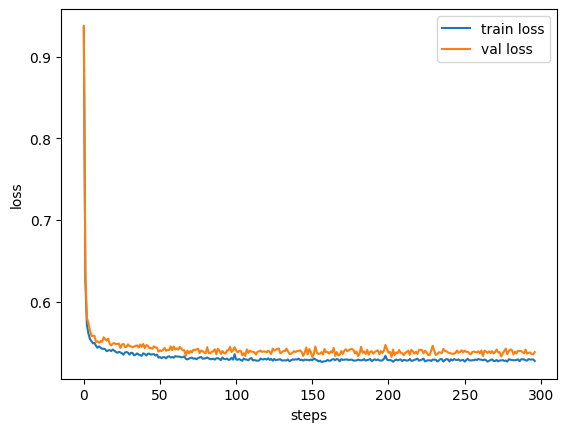

<!-- Optionally, you can display a sample image here if desired -->

## 12. Posterior Sampling

Sample from the posterior distribution using the trained model and visualize the results.

In [ ]:
from gensbi.models import SimformerWrapper


In [ ]:
obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
step_size = 0.01

# conditional sampling
def get_samples(vf_wrapped, idx, nsamples=10_000, edge_mask=undirected_edge_mask):
    observation, reference_samples =  task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    rng = jax.random.PRNGKey(45)

    key1,key2 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_theta)) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (1, dim_data, 1)) # n, dim_theta, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": edge_mask}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()

In [ ]:
vf_wrapped = SimformerWrapper(vf_model)

In [ ]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8
observation, reference_samples = task.get_reference(idx)

In [ ]:
samples = get_samples(vf_wrapped, idx, nsamples=100_000)[0]
# samples, true_param, reference_samples = get_samples(vf_wrapped, idx, nsamples=10)

### Visualize Posterior Samples

Plot the posterior samples as a 2D histogram.

In [ ]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

<Figure size 640x480 with 0 Axes>

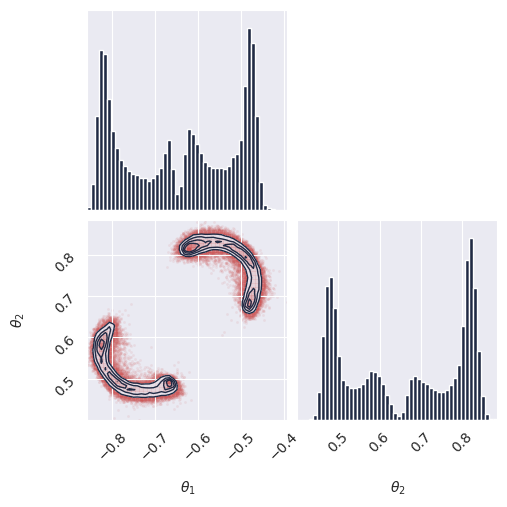

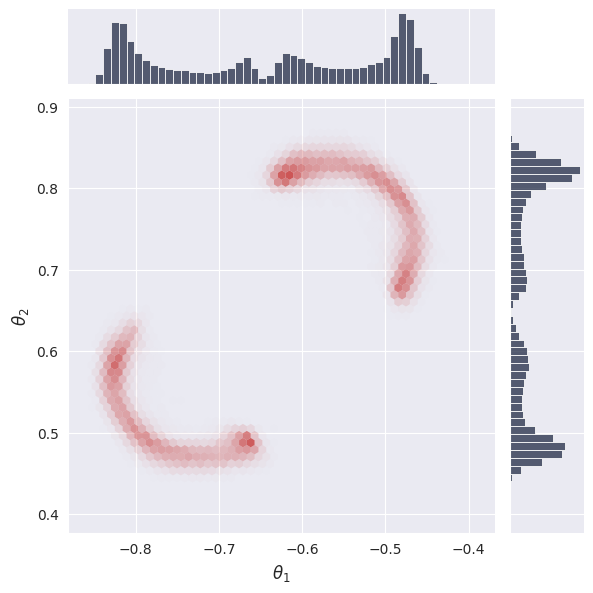

In [ ]:
plot_marginals(samples, plot_levels=False, gridsize=50)
plt.show()

plot_marginals(samples, plot_levels=False, gridsize=50, backend="seaborn")
plt.show()

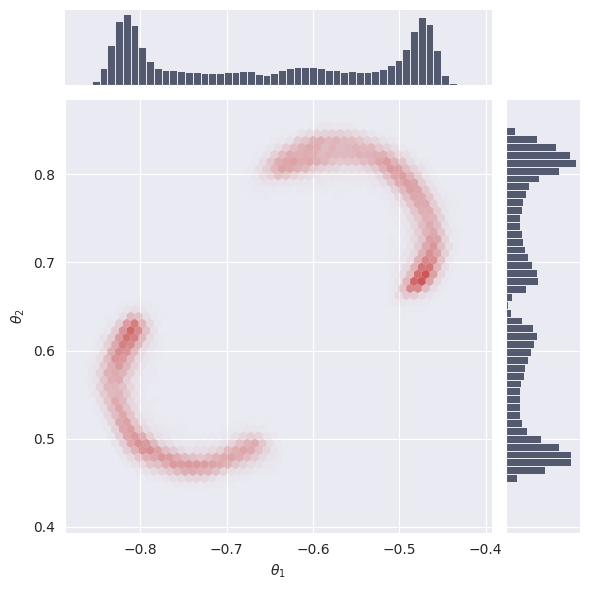

## 13. Posterior Evaluation

Evaluate the posterior by computing the likelihood on a grid and visualizing the results.

# evaluate the posterior

In [ ]:
idx = 8
observation, reference_samples = task.get_reference(idx)
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

In [ ]:
p0_cond = dist.Independent(
    dist.Normal(loc=jnp.zeros((2,)), scale=jnp.ones((2,))),
    reinterpreted_batch_ndims=1
)

In [ ]:
grid_size = 200


theta1 = jnp.linspace(-1, 1, grid_size)
theta2 = jnp.linspace(-1, 1, grid_size)
x_1 = jnp.meshgrid(theta1, theta2)

x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

# cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta,1)) # n, dim_theta, 1
# cond = jnp.broadcast_to(observation, (x_1.shape[0], dim_theta, 1)) # n, dim_theta, 1
cond = jnp.broadcast_to(observation, (1, dim_data)) # n, dim_theta, 1

obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": undirected_edge_mask}

In [ ]:
# get the logprob
# logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_cond.log_prob, model_extras=model_extras)
# create an y_init which has theta on the first position and x1,x2 on the second and third position

# y_init = p0_cond.sample(jax.random.PRNGKey(0), (x_1.shape[0],))  # n, dim_theta
y_init = x_1

exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]


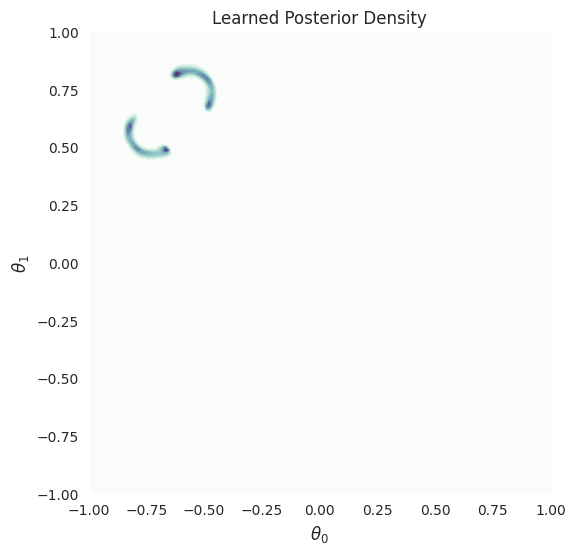

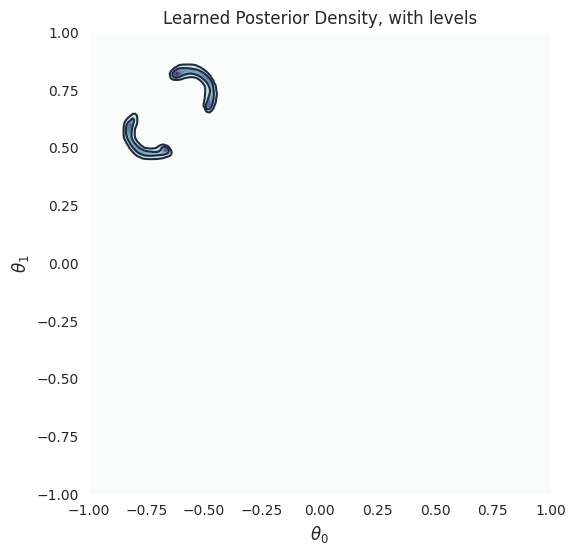

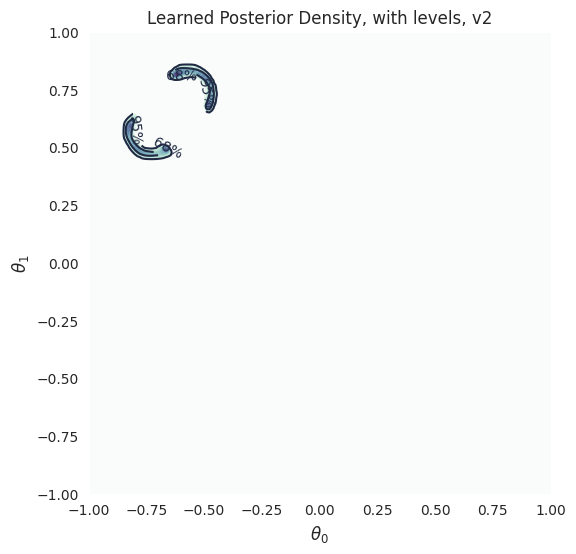

In [ ]:
x = theta1
y = theta2
Z = np.array(p.reshape((grid_size, grid_size)))


# plot_2d_dist_contour(x,y,Z, true_param=[true_param[0, 2], true_param[0, 3]])
plot_2d_dist_contour(x,y,Z, levels=None)
plt.title("Learned Posterior Density")
plt.xlabel(r"$\theta_0$", fontsize=12)
plt.ylabel(r"$\theta_1$", fontsize=12)

plt.show()

plot_2d_dist_contour(x,y,Z, print_labels=False)
plt.title("Learned Posterior Density, with levels")
plt.xlabel(r"$\theta_0$", fontsize=12)
plt.ylabel(r"$\theta_1$", fontsize=12)

plt.show()

plot_2d_dist_contour(x,y,Z, print_labels=True)
plt.title("Learned Posterior Density, with levels, v2")
plt.xlabel(r"$\theta_0$", fontsize=12)
plt.ylabel(r"$\theta_1$", fontsize=12)

plt.show()

## 14. Classifier Two-Sample Test (C2ST)

Evaluate the quality of the posterior samples using the C2ST metric. Values closer to 0.5 are better.

In [ ]:
from gensbi_examples.c2st import c2st

In [ ]:
idx = 8
observation, reference_samples = task.get_reference(idx)
samples = get_samples(vf_wrapped, idx, nsamples=reference_samples.shape[0])[0]


In [ ]:
c2st_accuracy = c2st(reference_samples, samples)

In [ ]:
c2st_accuracy #0.53

array(0.5198, dtype=float32)